# DATA4HR - Caso de negocio: Análisis de attrition


# Objetivos

- Identificar los empleados con alta probabilidad de renuncia (para esto, usaremos el histórico de datos para encontrar patrones)
- Buscar insights en los datos relacionados al personal
- Encontrar un modelo óptimo para identificar a los empleados



In [1]:
# importar librerias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
%matplotlib inline

In [2]:
#leer el archivo de datos a analizar
df_hr = pd.read_csv('HR_comma_sep.csv')

#renombrar la columna referida a departamento, cambiar 'sales' por 'departament'
df_hr.rename(columns={'sales': 'department'}, inplace=True)

# chequear summary del dataframe
df_hr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


Bien, el archivo está limpio, sin nulos, y listo para analizar

In [3]:
#veamos las primeras filas del archivo para ver datos de ejemplo
df_hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


Haremos análisis en función al campo left('se fue de la empresa', si es igual 1 significa que se fue, si es 0, la persona permanece en la empresa)

In [4]:
#veamos datos estadísticos descriptivos en forma de grilla
df_hr.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


A priori, vemos algunos datos interantes en satisfacion_level, last_evaluation ypromotion_last_5years. Luego veremos sus curvas de distribución para analizarlo en profundidad.

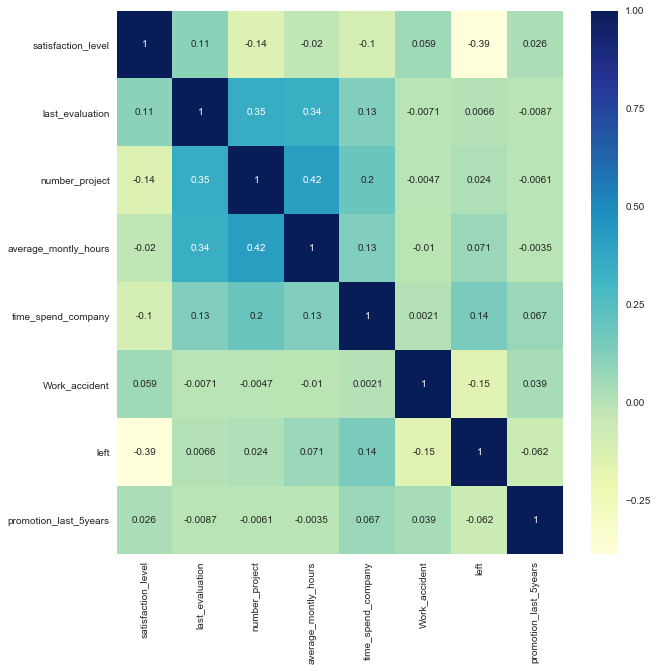

In [5]:
# Veamos si existen relaciones, asociaciones (correlaciones lineales de Pearson) entre variables.

plt.figure(figsize=(10,10))
sns.heatmap(data=df_hr.corr(), annot=True,cmap="YlGnBu")

Ok, vemos que el nivel de satisfacción influye en la decisión de irse o no de la empresa. 
También vemos otras correlaciones para analizar número de proyectos (number_project) y horas mensuales promedio (average_montly _hours)



In [6]:
#Veamos en un gráfico como se representan las distribuciones del nivel de satisfacción y el flag "se fue vs no se fue"

#antes del gráfico, tomemos en dataframes aparte, la info de las personas que se fueron o no
df_hr_left = df_hr[df_hr['left']==1]
df_hr_not_left = df_hr[df_hr['left']==0]

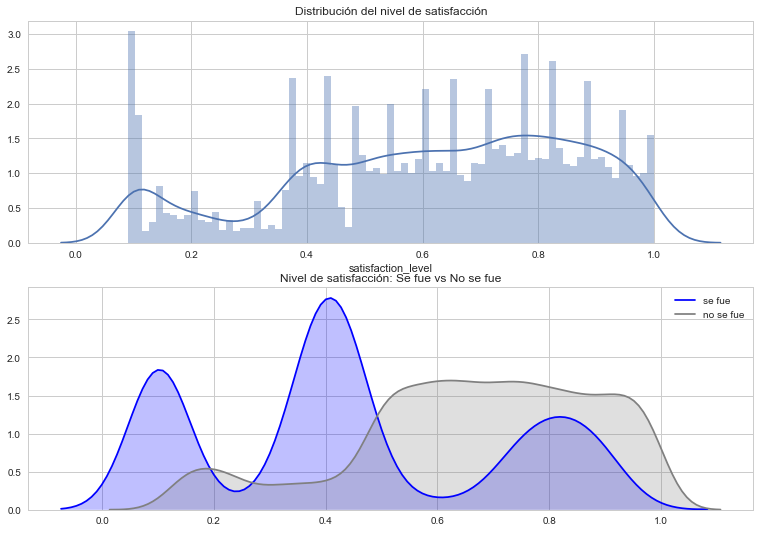

In [7]:
# ahora si, veamos los gráficos de las distribuciones
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(13,9))
sns.distplot(df_hr['satisfaction_level'], bins=75, ax=ax1)
ax1.set_title('Distribución del nivel de satisfacción')

sns.kdeplot(df_hr_left['satisfaction_level'], color='blue', ax=ax2, shade=True)
sns.kdeplot(df_hr_not_left['satisfaction_level'], color='grey', ax=ax2, shade=True)
ax2.set_title('Nivel de satisfacción: Se fue vs No se fue')
ax2.legend(['se fue', 'no se fue'])

ok, se ve que las clases presentan una separación 
- cuando el nivel de satisfacción es > 0.5, vemos que menos gente se va
- por otro lado, el pico máximo de las personas que se fueron, tuvieron un nivel de satisfacción alrededor de  0.4 de satisfacción.

Datos interesantes a tener en cuenta para seguir el análisis.

In [8]:
#veamos las variables a lo largo de todos los departamentos
department=df_hr.groupby('department').mean()
department

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
department,,,,,,,,
IT,0.618142,0.716830,3.816626,202.215974,3.468623,0.133659,0.222494,0.002445
RandD,0.619822,0.712122,3.853875,200.800508,3.367217,0.170267,0.153748,0.034307
accounting,0.582151,0.717718,3.825293,201.162973,3.522816,0.125163,0.265971,0.018253
hr,0.598809,0.708850,3.654939,198.684709,3.355886,0.120433,0.290934,0.020298
management,0.621349,0.724000,3.860317,201.249206,4.303175,0.163492,0.144444,0.109524
marketing,0.618601,0.715886,3.687646,199.385781,3.569930,0.160839,0.236597,0.050117
product_mng,0.619634,0.714756,3.807095,199.965632,3.475610,0.146341,0.219512,0.000000
sales,0.614447,0.709717,3.776329,200.911353,3.534058,0.141787,0.244928,0.024155
support,0.618300,0.723109,3.803948,200.758188,3.393001,0.154778,0.248991,0.008973


## Analicemos en particular las personas que se fueron

In [9]:
df_hr_left.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3571 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       3571 non-null float64
last_evaluation          3571 non-null float64
number_project           3571 non-null int64
average_montly_hours     3571 non-null int64
time_spend_company       3571 non-null int64
Work_accident            3571 non-null int64
left                     3571 non-null int64
promotion_last_5years    3571 non-null int64
department               3571 non-null object
salary                   3571 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 306.9+ KB


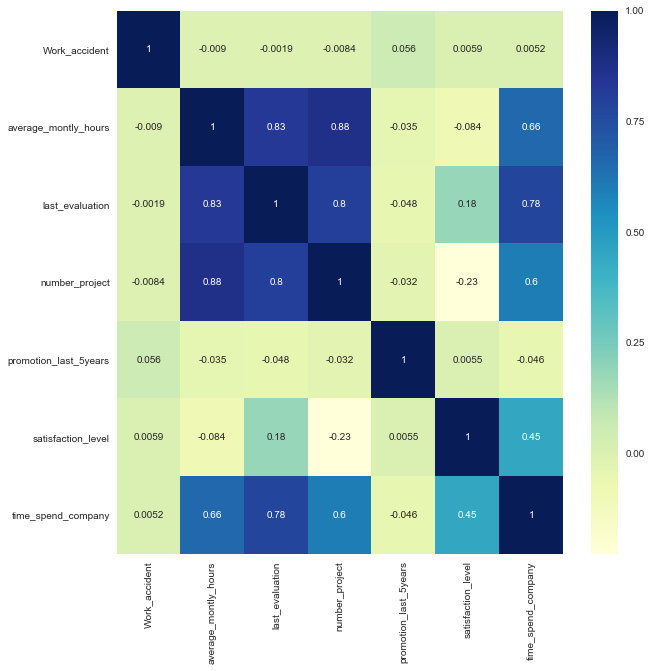

In [10]:
#veamos la matriz de correlación solo de las personas que se fueron

plt.figure(figsize=(10,10))
sns.heatmap(data=df_hr_left[df_hr_left.columns.difference(['left'])].corr('pearson'), annot=True,cmap="YlGnBu")

ok, vemos asociaciones interesantes: promedio_horas_mensuales  y ultima evaluacion/numero_de_proyectos 
tienen una relacion muy fuerte

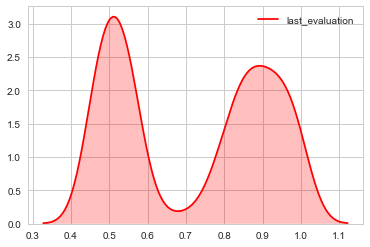

In [11]:
#continuemos analizando la gente que se fue y sus características.

#Comencemos viendo la distribución de última evaluacion.
ax = sns.kdeplot(df_hr_left.last_evaluation, shade=True, color="r" )

Aqui vemos dos picos interesantes. el mas importante es el de la derecha donde encontramos personas con una alta nota 
en la última evaluación y se fue de la empresa.
Del lado izquierdo vemos un pico con un promedio de nota mas bajo. Aqui podemos separar en buenos empleados (nota > .7) y no tan buenos (nota < .7)

### El salario y la cantidad de años en la empresa son predictores de renuncia?

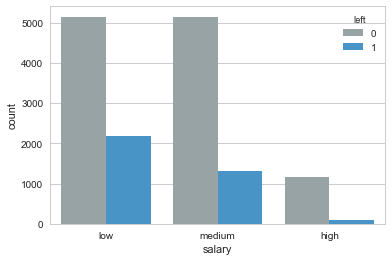

In [12]:
#veamos el salario usando gráfico de barras
flatui = [ "#95a5a6","#3498db"]
sns.countplot(x='salary', data= df_hr , hue='left', palette=sns.color_palette(flatui))

ok, aqui vemos que significativamente los empleados con sueldos bajo o medio renuncian mas en proporción a los empleados que mas cobran. Tiene sentido.

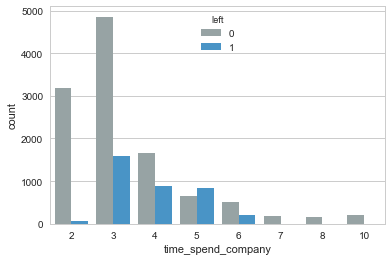

In [38]:
#veamos la cantidad de año en la empresa usando diagramas de cajas
sns.countplot(x='time_spend_company', data= df_hr , hue='left', palette=sns.color_palette(flatui))

En verde, las cantidad d elos que se fueron. Vemos que entre 3 y 6 años, la proporcion de personas que dejaron la empresa es alta.

### Veamos como se relacionan el nivel de satisfacción y la última evaluación

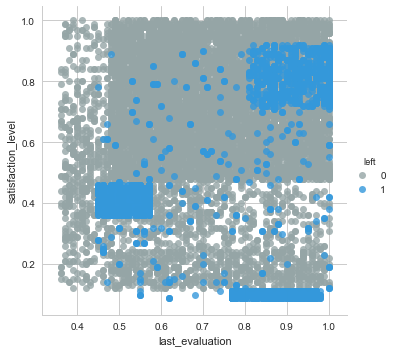

In [14]:
sns.lmplot(x="last_evaluation", y="satisfaction_level", data=df_hr, hue='left', fit_reg=False, palette=sns.color_palette(flatui))

Interesante, vemos que existen 3 grupos que se fueron (en verde) con diferentes características en función al nivel de satisfacción
- Nivel de satisfacción promedio .4 y última evaluación promedio .5 --a priori no serian los relevantes a revisar
- Nivel de satisfacción promedio < .2 y alta nota de evaluación > .7 -- Riesgo alto. Pueden tratarse de grandes empleados poco o nada satisfechos y con alto grado de conocimiento. Alerta.
- Nivel de satisfacción alto > .7 y alta nota de evaluación > .7 -- buenos empleados y satisfechos. Quizas se fueron por mejores ofertas?

## Bien, ahora buscaremos el mejor modelo de Machine Learning (ML) para identificar a las probables renuncias a futuro

###  Primero usaremos el modelo de Regresión logística para clasificar las personas que se pueden ir

In [15]:
#antes de crear el modelo, pasamos a numérico la variable categórica Salario
map_salary = {'low': 0, 'medium': 1, 'high': 2} 
df_hr.replace({'salary': map_salary}, inplace=True)

In [16]:
%%time
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

X_lr = df_hr.drop(['left', 'department'], axis=1)
y_lr = df_hr['left']
X_lr = preprocessing.scale(X_lr)

#usaremos como técnica anti-overfitting el método split-test
X_train, X_test, y_train, y_test = train_test_split(X_lr,y_lr,test_size = 0.3, random_state = 0)

model_lr = LogisticRegression()
param_lr = {'C' : np.linspace(1, 10, 20)}

clf_lr = GridSearchCV(model_lr, param_lr, cv=5, return_train_score=False)

clf_lr.fit(X_lr, y_lr)

print('La precisión promedio para Regression Logística es es: {}'.format(round(clf_lr.best_score_, 5)))


La precisión promedio para Regression Logística es es: 0.77192
Wall time: 1.7 s


A Priori 77% es una métrica de accuracy regular, pero veamos las valores de performance

In [17]:
#creamos la serie con la nueva clase
y_pred = clf_lr.predict(X_test)

In [18]:
#veamos la matriz de confusión, y las metricas

from sklearn import metrics
print(metrics.confusion_matrix(y_test,y_pred))
print(metrics.recall_score(y_test,y_pred))
print(metrics.precision_score(y_test,y_pred))

[[3200  262]
 [ 662  376]]
0.362235067437
0.58934169279


Mmm... si bien cerca del 80% el modelo acierta el resultado, para el caso nuestro, donde nos interesa si acierta en los casos que la persona se va de la empresa, el porcentaje de sensitividad (recall) es muy bajo, solo un 36% de las veces el modelo acierta que si realmente se fue, nosotros acertamos. Si bien, podriamos bajar el umbral para lograr mas precisión, veamos otro modelo de ML, porque la performance de este modelo es mala.
El modelo no es robusto, y probaremos con otra técnica! 



### Ahora veamos el potente algoritmo de clasificación SVM (Support Vector Machine)

In [19]:
# Debajo usaremos cross_validation para evitar overfitting

In [20]:
%%time
from sklearn.svm import SVC

X_svc = df_hr.drop(['left', 'department'], axis=1)
y_svc = df_hr['left']

X_svc = preprocessing.scale(X_svc)

#ejecutamos support vector classifier con los hyperparámetros por defecto
model_svc = SVC(probability=True)

scores = cross_val_score(model_svc,X_svc,y_svc,cv=10,scoring="recall")

print('El accuracy, la cantidad de aciertos es de: ',cross_val_score(model_svc,X_svc,y_svc,cv=10,scoring="accuracy").mean())
model_svc.fit(X_svc, y_svc)

print('La media del recall -sensitivity- es: ',scores.mean()) 

El accuracy, la cantidad de aciertos es de:  0.964865240473
La media del recall -sensitivity- es:  0.909265605684
Wall time: 1min 27s


Aqui vemos que casi el 91%  de las veces que la persona se fue, nosotros predecimos lo mismo. Es un muy buen ratio para el modelo

In [21]:
print('La precision, la cantidad de negativos acertados es de: ',cross_val_score(model_svc,X_svc,y_svc,cv=10,scoring="precision").mean())

La precision, la cantidad de negativos acertados es de:  0.941542737242


In [22]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred_svc = cross_val_predict(model_svc,X_svc,y_svc,cv=10)
conf_mat_svc = confusion_matrix(y_svc,y_pred_svc)

In [23]:
conf_mat_svc

array([[11225,   203],
       [  324,  3247]], dtype=int64)

Mirando la matriz de confusión, se corroboran las métricas, y se observan muy buenos números en relacion target-predicted.

In [24]:
fpr, tpr, thresholds = metrics.roc_curve(y_svc,y_pred_svc)

Text(0,0.5,'True positive rate. Sensitividad')

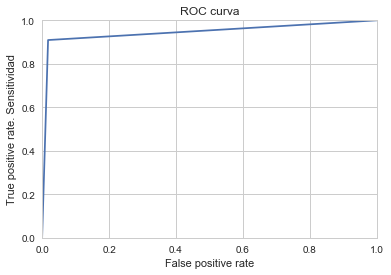

In [25]:
plt.plot(fpr,tpr)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.title('ROC curva')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate. Sensitividad')

La curva ROC tiene muy buena performance, como se ve en la imagen. Alto grado de aciertos en true positives, y pocos false positives.

In [26]:
#Abajo podemos confirmarlo con el área cubierta bajo la curva.
print('ROC AUC: ',cross_val_score(model_svc,X_svc,y_svc,cv=10,scoring="roc_auc").mean())

ROC AUC:  0.977411390032


In [27]:
#veamos las probabilidades de salida
y_pred_svc_proba = model_svc.predict_proba(X_svc)

In [28]:
predicted_values_svc = pd.Series(model_svc.predict(X_svc), index=y_svc.index)

In [29]:
proba_values_svc = pd.Series(model_svc.predict_proba(X_svc)[:,1], index=y_svc.index)

In [30]:
#agrupamos en un vector los empleados que permanecen en la empresa con riesgo de irse
empleados_con_riesgo = []
for index in y_svc.index:
    if (predicted_values_svc.loc[index] == 1) and (y_svc.loc[index] == 0):
        empleados_con_riesgo.append(index)

In [31]:
df_empleados_con_riesgo = pd.DataFrame(index=empleados_con_riesgo)

In [32]:
df_empleados_con_riesgo['prob_renuncia'] = proba_values_svc


In [33]:
print('Los ids de los empleados con riesgo de irse son:')

Los ids de los empleados con riesgo de irse son:


In [34]:
format(empleados_con_riesgo)

'[2011, 2094, 2206, 2214, 2410, 2415, 2421, 2475, 2498, 2550, 2570, 2703, 2723, 2801, 2842, 3038, 3056, 3079, 3106, 3114, 3160, 3326, 3345, 3518, 3710, 3780, 3890, 3921, 3989, 4076, 4240, 4392, 4455, 4519, 4534, 4621, 4673, 4774, 4783, 4830, 4837, 4843, 4879, 4892, 4932, 4982, 5072, 5104, 5149, 5151, 5180, 5270, 5356, 5431, 5436, 5565, 5762, 5840, 5847, 5944, 5949, 5994, 6012, 6055, 6056, 6076, 6086, 6189, 6228, 6263, 6290, 6319, 6358, 6448, 6457, 6466, 6472, 6497, 6644, 6726, 6728, 6811, 6826, 6854, 6896, 6928, 7004, 7006, 7077, 7135, 7223, 7241, 7244, 7251, 7313, 7323, 7355, 7384, 7430, 7443, 7560, 7727, 7732, 7745, 7762, 7782, 7805, 7818, 7918, 7983, 7989, 8010, 8022, 8128, 8157, 8193, 8257, 8270, 8301, 8335, 8394, 8416, 8451, 8489, 8522, 8553, 8591, 8682, 8741, 8891, 8895, 9059, 9171, 9175, 9220, 9227, 9388, 9481, 9487, 9515, 9582, 9689, 9729, 9776, 9781, 9824, 9828, 9842, 9881, 9913, 10055, 10098, 10100, 10140, 10159, 10223, 10237, 10294, 10438, 10501, 10546, 10671, 10756, 10790, 

In [35]:
df_hr_empleados_con_riesgo = df_hr[df_hr.index.isin(empleados_con_riesgo)]

In [36]:
df_hr_empleados_con_riesgo['prob_renuncia'] = df_empleados_con_riesgo.loc[:,'prob_renuncia']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
df_hr_empleados_con_riesgo.head(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,prob_renuncia
2011,0.34,0.39,2,136,3,0,0,0,sales,1,0.893912
2094,0.48,0.56,2,151,3,0,0,0,hr,1,0.890311
2206,0.16,0.98,5,284,5,0,0,0,IT,1,0.741272
2214,0.59,0.52,2,149,3,0,0,0,accounting,1,0.687215
2410,0.58,0.50,2,132,3,0,0,0,support,1,0.706015
2415,0.92,0.97,4,238,5,1,0,0,support,1,0.858823
2421,0.69,0.76,5,255,6,0,0,0,technical,0,0.762352
2475,0.32,0.42,2,99,4,0,0,0,technical,0,0.796688
2498,0.45,0.52,2,105,3,0,0,0,technical,0,0.845168
2550,0.46,0.62,2,187,3,0,0,0,hr,0,0.577309
